In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [34]:
class Config:

    def __init__(self):
        
        # 初始化数据集参数
        self.data_path = 'data/weeks/all_week_data.csv'
        self.drop_column = ['Date']
        self.label = 'Close'
        self.seq_len = 4
        # self.mode = {'train':'train', 'val':'val', 'test':'test'}
        self.train_split = 0.8
        self.test_split = 0.1      
        self.val_split = 1 - self.train_split - self.test_split
        # 此处应写 train + val + test > 1的异常
        
        # 初始化模型参数
        self.data_last_dim_len = self.load_data_last_dim_len()
        # self.n_vocab = self.load_data_last_dim_len()
        # self.embed_size = [6]
        self.input_size = [6, 1]
        self.lstm_hidden_size = [128, 128]
        self.lstm_num_layers = [1, 1]
        self.lstm_dropout = 0.2
        self.is_bidirectional = False
        self.layer_dropout = 0.5
        self.dense_size = [32]
        self.output_size = 1

        # 初始化训练参数
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 32
        self.is_shuffle = True

        self.learn_rate = 0.2
        self.train_epochs = 1
        

    def load_data_last_dim_len(self):

        table = pd.read_csv(self.data_path)

        for drop_col in self.drop_column:

            table = table.drop(drop_col, axis=1)

        tb = np.array(table)
        
        # print(tb.shape[tb.ndim - 1])
        return tb.shape[tb.ndim - 1]

In [35]:
# print(len(torch.tensor([])))
a = torch.tensor([[1,2]]).float()
print(a.shape)
print(a.mean(1))
print(a.var(1, unbiased=False))
print(nn.functional.layer_norm(a,(2,)))

torch.Size([1, 2])
tensor([1.5000])
tensor([0.2500])
tensor([[-1.0000,  1.0000]])


In [36]:
a = torch.tensor([1,2,3,4])
print(a.shape)
print(a[1:])

torch.Size([4])
tensor([2, 3, 4])


In [37]:
class PriceData(Dataset):

    def __init__(self, cfg, mode):

        super(PriceData, self).__init__()

        self.data_path = cfg.data_path  
        self.ori_sample_num = 0

        self.feature_mean = []
        self.feature_var = []                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

        self.datas, self.labels = self.load_data(cfg)

        self.train_split, self.val_split, self.test_split = 0, 0, 0
        
        print('feature_mean.len:', len(self.feature_mean), len(self.feature_var))

        # print(self.datas.size(), len(self.labels))

        if mode == 'train':

            self.datas = self.datas[:int(len(self.datas) * cfg.train_split)]
            self.labels = self.labels[:int(len(self.labels) * cfg.train_split)]

        elif mode == 'validation':

            self.datas = self.datas[int(len(self.datas) * cfg.train_split) 
                : int(len(self.datas) * (cfg.train_split + cfg.test_split))]
            self.labels = self.labels[int(len(self.labels) * cfg.train_split) 
                : int(len(self.labels) * (cfg.train_split + cfg.test_split))]
            
        elif mode == 'test':

            self.datas = self.datas[int(
                len(self.datas) * (cfg.train_split + cfg.val_split)):]
            self.labels = self.labels[int(
                len(self.labels) * (cfg.train_split + cfg.val_split)):]

            self.test_mean = self.feature_mean[
                int(len(self.feature_mean) * (cfg.train_split + cfg.val_split)):]
            self.test_var = self.feature_var[
                int(len(self.feature_var) * (cfg.train_split + cfg.val_split)):]
            
            print('test_feature.len:', len(self.test_mean), len(self.test_var))

        print('!!!', mode, 'dataset_info:', len(self.datas), self.datas.shape,
              'label_info:', len(self.labels), self.labels.shape)


    def __getitem__(self, index):

        data, label = self.datas[index], self.labels[index]

        return data, label
    

    def __len__(self):

        return len(self.datas)
    

    def load_data(self, cfg):

        table = pd.read_csv(cfg.data_path)

        for drop_col in cfg.drop_column:

            table = table.drop(drop_col, axis=1)

        label_idx = table.columns.get_loc(cfg.label)
        print('label_idx:', label_idx)

        self.ori_sample_num = len(table)
        print(
            'ori_table.len:', len(table), 
            '\nori_table.columns:', len(table.columns), 'table.col_name:', table.columns,
            '\nori_table.values:', len(table.values),
            '\nori_table.shape:', table.shape
        )

        table = torch.tensor(np.array(table)).float()
        self.feature_mean = table.mean(1)[cfg.seq_len - 1:]
        self.feature_var = table.var(1, unbiased=False)[cfg.seq_len - 1:]
        table = nn.functional.layer_norm(table, (6,))
        print('table.type:', type(table), 'table.shape:', table.shape)

        datas = torch.tensor([])
        labels = torch.tensor([])
        # features_amount = len(table.columns)

        for index in range(len(table) - cfg.seq_len + 1):
            
            # datas.append(table[index : index + cfg.seq_len])
            # labels.append(table[cfg.label][index + cfg.seq_len])
            if len(datas) == 0 and len(labels) == 0:

                datas = table[index : index + cfg.seq_len, :].unsqueeze(0)
                # print('datas.shape', datas.shape)
                # print('datas.len:', len(datas))

                labels = table[index + cfg.seq_len - 1, label_idx].view(1)
                # print('labels.shape:', labels.shape)
                # print('++datas', datas, '++label',labels)
            
            else:

                datas = torch.cat(
                    [datas, table[index : index + cfg.seq_len, :].unsqueeze(0)], 
                    dim=0
                )

                labels = torch.cat(
                    [labels, table[index + cfg.seq_len - 1, label_idx].view(1)], 
                    dim=0
                )
                # print('datas.shape:', datas.shape)
                # print('++datas', datas, '++label',labels)

                # datas.append(table[index : index + cfg.seq_len, :])
                # labels.append(table[index + cfg.seq_len, label_idx])

            # print(datas)
            # print(labels)

            # if len(datas) == 2 :
            #     break

        print('datas.type:', type(datas[0]), type(labels))

        # datas = torch.tensor(np.array(datas)).float()
        
        # labels = torch.tensor(np.array(labels)).float()

        # print('ori_data_set.shape:', datas.shape, 'labels.shape:', labels.shape)

        print('ori_data_set.shape:', datas.shape, 'labels.shape:', labels.shape, labels)

        return datas, labels


In [38]:
cfg = Config()
# db = PriceData(cfg, 'train')
# db = PriceData(cfg, 'validation')
db = PriceData(cfg, 'test')

# a = [0, 1, 2, 3, 4, 5, 6, 7]
# print(a[:-9])
# j = 4
# for i in range(len(a) - j + 1):
#     print(a[i:i+j])
print('+++++++++++++++++')
for x, y in db:
    print(x, y)
    break
del db

label_idx: 0
ori_table.len: 1826 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 1826 
ori_table.shape: (1826, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([1826, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([1823, 4, 6]) labels.shape: torch.Size([1823]) tensor([ 0.8137,  0.7141,  0.6337,  ..., -0.4024, -0.4201, -0.2622])
feature_mean.len: 1823 1823
test_feature.len: 183 183
!!! test dataset_info: 183 torch.Size([183, 4, 6]) label_info: 183 torch.Size([183])
+++++++++++++++++
tensor([[-0.4198, -0.4267, -0.4188, -0.4275,  2.2340, -0.5413],
        [-0.4149, -0.4171, -0.4136, -0.4201,  2.2327, -0.5670],
        [-0.4136, -0.4163, -0.4121, -0.4167,  2.2323, -0.5736],
        [-0.3359, -0.3504, -0.3346, -0.3528,  2.2008, -0.8272]]) tensor(-0.3359)


In [39]:
def data_loader(data, cfg):

    return DataLoader(
        data,
        batch_size=cfg.batch_size,
        shuffle=cfg.is_shuffle,
        # num_workers= 4
    )

In [40]:
if __name__ == '__main__':

    cfg = Config()
    db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'test')

    train_data = data_loader(db, cfg)

    for i, batch in enumerate(train_data):

        data, label = batch
        print('i_data.shape:', data.shape, 'i_label.shape:', label.shape)
        print(data[0])

        # embed = nn.Embedding(6,2)
        # print(embed(data))

        break

    del db, cfg, train_data, data, label, batch
    # dataloader = DataLoader(db, batch_size=2)

    # for i, batch in enumerate(dataloader):

    #     print(batch)

    # del cfg, db, dataloader

label_idx: 0
ori_table.len: 1826 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 1826 
ori_table.shape: (1826, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([1826, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([1823, 4, 6]) labels.shape: torch.Size([1823]) tensor([ 0.8137,  0.7141,  0.6337,  ..., -0.4024, -0.4201, -0.2622])
feature_mean.len: 1823 1823
!!! validation dataset_info: 182 torch.Size([182, 4, 6]) label_info: 182 torch.Size([182])
i_data.shape: torch.Size([32, 4, 6]) i_label.shape: torch.Size([32])
tensor([[-0.4317, -0.4305, -0.4287, -0.4328,  2.2351, -0.5115],
        [-0.4322, -0.4293, -0.4284, -0.4343,  2.2351, -0.5109],
        [-0.4110, -0.4187, -0.4103, -0.4207,  2.2324, -0.5718],
        [-0.4300, -0.4254, -0.4235, -0.4309,  2.2346, -0.5248]])


In [41]:
import torch.nn as nn
from torch import optim
from torcheval.metrics.functional import r2_score

In [42]:
class Predict(nn.Module):

    def __init__(self, cfg):

        super(Predict, self).__init__()

        self.layer_norm = nn.LayerNorm(cfg.data_last_dim_len)

        # self.embedding = nn.Embedding(cfg.n_vocab, cfg.embed_size)

        self.lstm1 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[0],
            cfg.lstm_hidden_size[0],
            cfg.lstm_num_layers[0],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.lstm2 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[1],
            cfg.lstm_hidden_size[1],
            cfg.lstm_num_layers[1],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.dropout = nn.Dropout(cfg.layer_dropout)
        
        self.dense1 = nn.Linear(cfg.lstm_hidden_size[1], cfg.dense_size[0])
        self.dense2 = nn.Linear(cfg.dense_size[0], cfg.output_size)

        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        # print('input_dataset.type:', x.type())
        # norm = self.layer_norm(x)
        # print('norm.type:', norm.size())
        lstm1, _ = self.lstm1(x)
        # print('lstm1.type:', lstm1.size())
        dropout1 = self.dropout(lstm1)
        # print('dropout1.type:', dropout1.size())
        lstm2, _ = self.lstm2(dropout1)
        # print('lstm2.type:', lstm2.size())
        lstm_last = lstm2[:, -1, :]
        # print('lstm_last.type:', lstm_last.size())
        dropout2 = self.dropout(lstm_last)
        # print('dropout2.type:', dropout2.size())
        fc1 = self.dense1(dropout2)
        # print('fc1.type:', fc1.size())
        # fc1 = self.dropout1(fc1)
        rl_out = self.relu(fc1)
        # print('rl_out.type:', rl_out.size())
        out = self.dense2(rl_out).squeeze()
        # print('out.type:', out.size())

        # out = self.layer_norm(x)
        # out, _ = self.lstm1(out)
        # out = self.dropout1(out)
        # out, _ = self.lstm2(out)
        # out = self.dropout2(out)
        # out = self.dense1(out)
        # out = self.relu(out)
        # out = self.dense2(out)

        return out
        


In [43]:
class Config:

    def __init__(self):
        
        # 初始化数据集参数
        self.data_path = 'data/weeks/all_week_data.csv'
        self.drop_column = ['Date']
        self.label = 'Close'
        self.seq_len = 4
        # self.mode = {'train':'train', 'val':'val', 'test':'test'}
        self.train_split = 0.8
        self.test_split = 0.1      
        self.val_split = 1 - self.train_split - self.test_split
        # 此处应写 train + val + test > 1的异常
        
        # 初始化模型参数
        self.data_last_dim_len = self.load_data_last_dim_len()
        # self.n_vocab = self.load_data_last_dim_len()
        # self.embed_size = [6]
        self.input_size = [6, 128]
        self.lstm_hidden_size = [128, 128]
        self.lstm_num_layers = [1, 1]
        self.lstm_dropout = 0.2
        self.is_bidirectional = False
        self.layer_dropout = 0.5
        self.dense_size = [32]
        self.output_size = 1

        # 初始化训练参数
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 32
        self.is_shuffle = True

        self.learn_rate = 0.001
        self.train_epochs = 100
        

    def load_data_last_dim_len(self):

        table = pd.read_csv(self.data_path)

        for drop_col in self.drop_column:

            table = table.drop(drop_col, axis=1)

        tb = np.array(table)
        
        # print(tb.shape[tb.ndim - 1])
        return tb.shape[tb.ndim - 1]

In [44]:
cfg = Config()
# print(cfg.device)
model = Predict(cfg)
model.to(cfg.device)
print(model)

Predict(
  (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)


In [45]:
def model_structure(model):
    blank = ' '
    print('-' * 90)
    print('|' + ' ' * 11 + 'weight name' + ' ' * 10 + '|' \
          + ' ' * 15 + 'weight shape' + ' ' * 15 + '|' \
          + ' ' * 3 + 'number' + ' ' * 3 + '|')
    print('-' * 90)
    num_para = 0
    type_size = 1  # 如果是浮点数就是4

    for index, (key, w_variable) in enumerate(model.named_parameters()):
        if len(key) <= 30:
            key = key + (30 - len(key)) * blank
        shape = str(w_variable.shape)
        if len(shape) <= 40:
            shape = shape + (40 - len(shape)) * blank
        each_para = 1
        for k in w_variable.shape:
            each_para *= k
        num_para += each_para
        str_num = str(each_para)
        if len(str_num) <= 10:
            str_num = str_num + (10 - len(str_num)) * blank

        print('| {} | {} | {} |'.format(key, shape, str_num))
    print('-' * 90)
    print('The total number of parameters: ' + str(num_para))
    print('The parameters of Model {}: {:4f}M'.format(model._get_name(), num_para * type_size / 1000 / 1000))
    print('-' * 90)

model_structure(model)

------------------------------------------------------------------------------------------
|           weight name          |               weight shape               |   number   |
------------------------------------------------------------------------------------------
| layer_norm.weight              | torch.Size([6])                          | 6          |
| layer_norm.bias                | torch.Size([6])                          | 6          |
| lstm1.weight_ih_l0             | torch.Size([512, 6])                     | 3072       |
| lstm1.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |
| lstm1.bias_ih_l0               | torch.Size([512])                        | 512        |
| lstm1.bias_hh_l0               | torch.Size([512])                        | 512        |
| lstm2.weight_ih_l0             | torch.Size([512, 128])                   | 65536      |
| lstm2.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |

In [46]:
# from torchsummary import summary

# # summary(model, (1823, 4, 6))
# model1 = Predict(cfg)
# summary(model1,(1823, 4, 6),device='cpu')
# del model1

In [47]:
# from torchstat import stat

# stat(model, (1823, 4, 6))

In [48]:
for name, module in model.named_modules():
    print('modules:', name, '--', module)

modules:  -- Predict(
  (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)
modules: layer_norm -- LayerNorm((6,), eps=1e-05, elementwise_affine=True)
modules: lstm1 -- LSTM(6, 128)
modules: lstm2 -- LSTM(128, 128)
modules: dropout -- Dropout(p=0.5, inplace=False)
modules: dense1 -- Linear(in_features=128, out_features=32, bias=True)
modules: dense2 -- Linear(in_features=32, out_features=1, bias=True)
modules: relu -- ReLU(inplace=True)


In [49]:
for name, m in model.named_children():
    print(name, '>>>', m)

layer_norm >>> LayerNorm((6,), eps=1e-05, elementwise_affine=True)
lstm1 >>> LSTM(6, 128)
lstm2 >>> LSTM(128, 128)
dropout >>> Dropout(p=0.5, inplace=False)
dense1 >>> Linear(in_features=128, out_features=32, bias=True)
dense2 >>> Linear(in_features=32, out_features=1, bias=True)
relu >>> ReLU(inplace=True)


In [50]:
train_db = PriceData(cfg, 'train')
    # db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'test')

train_loader = data_loader(train_db, cfg)

print('++++++++++++++++++++++++++++')
print('train.type', type(train_loader), len(train_loader))
for x, y in train_loader:
    print(x)
    print(y)
    break

label_idx: 0
ori_table.len: 1826 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 1826 
ori_table.shape: (1826, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([1826, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([1823, 4, 6]) labels.shape: torch.Size([1823]) tensor([ 0.8137,  0.7141,  0.6337,  ..., -0.4024, -0.4201, -0.2622])
feature_mean.len: 1823 1823
!!! train dataset_info: 1458 torch.Size([1458, 4, 6]) label_info: 1458 torch.Size([1458])
++++++++++++++++++++++++++++
train.type <class 'torch.utils.data.dataloader.DataLoader'> 46
tensor([[[-0.1941, -0.1900, -0.1666, -0.1941,  2.0433, -1.2984],
         [-0.3691, -0.3857, -0.3605, -0.3889,  2.2188, -0.7146],
         [-0.3807, -0.3735, -0.3724, -0.3922,  2.2205, -0.7018],
         [-0.3817, -0.3775, -0.3733, -0.3851,  2.2204, -0.7028]],

        [[-0.3525, -0.3569, -0.3474, -0.3632,  2.

In [51]:
val_db = PriceData(cfg, 'validation')

val_loader = data_loader(val_db, cfg)
print('++')
print('val.type', type(val_loader), len(val_loader))

label_idx: 0
ori_table.len: 1826 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 1826 
ori_table.shape: (1826, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([1826, 6])


datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([1823, 4, 6]) labels.shape: torch.Size([1823]) tensor([ 0.8137,  0.7141,  0.6337,  ..., -0.4024, -0.4201, -0.2622])
feature_mean.len: 1823 1823
!!! validation dataset_info: 182 torch.Size([182, 4, 6]) label_info: 182 torch.Size([182])
++
val.type <class 'torch.utils.data.dataloader.DataLoader'> 6


In [52]:
test_db = PriceData(cfg, 'test')
cfg.is_shuffle = False
test_loader = data_loader(test_db, cfg)
print('++')
print('test.type', type(test_loader), len(test_loader))

label_idx: 0
ori_table.len: 1826 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 1826 
ori_table.shape: (1826, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([1826, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([1823, 4, 6]) labels.shape: torch.Size([1823]) tensor([ 0.8137,  0.7141,  0.6337,  ..., -0.4024, -0.4201, -0.2622])
feature_mean.len: 1823 1823
test_feature.len: 183 183
!!! test dataset_info: 183 torch.Size([183, 4, 6]) label_info: 183 torch.Size([183])
++
test.type <class 'torch.utils.data.dataloader.DataLoader'> 6


In [53]:
optimizer = optim.Adam(model.parameters(), lr=cfg.learn_rate)
criteon = nn.MSELoss().to(cfg.device)

In [54]:
import visdom

viz = visdom.Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss', legend=['loss']))
viz.line([0.], [0.], win='validation_acc', opts=dict(title='validation acc', legend=['acc']))
# viz.line([0.], [-1.], win='train_loss_epoch', opts=dict(title='train loss&acc', legend=['loss', 'acc']))

# viz.line([loss.item()], [global_step], win='train_loss', update='append')

Setting up a new session...


'validation_acc'

In [55]:
def evaluate(model, loader, mode='train'):

    r2 = 0
    total = len(loader.dataset)
    pred = []

    for x, y in loader:

        x, y = x.to(cfg.device), y.to(cfg.device)
        # print('y', y)
        with torch.no_grad():
            logits = model(x)
        print('logits', logits)
        print('y', y)
        r2 += r2_score(logits, y).sum().float().item()
        # print(len(logits))

        if mode == 'untrain':
            
            for i in range(len(logits)):

                pred.append(logits[i].item())

    if mode == 'untrain':
        
        return r2 / total, pred

    return r2 / total

In [56]:
global_step1 = 0
global_step2 = 0

best_r2 = -100

for epoch in range(cfg.train_epochs):

    model.train()
    for i, batch in enumerate(train_loader):

        data, label = batch
        data = data.to(cfg.device)
        label = label.to(cfg.device)
        # print('i_data.shape:', data.shape, 'i_label.shape:', label.shape)

        pred = model(data)
        loss = criteon(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print('loss.item:',loss.item())
        
        # viz.line([loss.item()], [global_step], win='train_loss', update='append')
        global_step1 += 1
 
        # print(type(np.array(loss.item())))
        
        # if epoch % 10 == 0 and i % 32 == 0:
        #     print('loss:', loss)
        # break

    # break
    
    # viz.line([loss.item()], [epoch], win='train_loss', update='append')

    model.eval()
    with torch.no_grad():
        
    #     evalute = 0
        
        for x, y in val_loader:
            
            r2 = evaluate(model, val_loader)

            if r2 > best_r2:

                best_r2 = r2
                best_epoch = epoch

                torch.save(model.state_dict(), 'best.mdl')

            # viz.line([torch.Tensor.cpu(r2)], [global_step2], win='validation_acc', update='append')
            viz.line([r2], [global_step2], win='validation_acc', update='append')
            global_step2 += 1

            # break

    # break

    # if epoch % 10 == 0 and i % 32 == 0:
    #     print('loss:', loss)



logits tensor([-0.1493, -0.2353, -0.2888, -0.3160, -0.3267, -0.3280, -0.3257, -0.3236,
        -0.3210, -0.3188, -0.3178, -0.3175, -0.3172, -0.3177, -0.3097, -0.3112,
        -0.3129, -0.3150, -0.3155, -0.3154, -0.3161, -0.3163, -0.3176, -0.3178,
        -0.3172, -0.3175, -0.3166, -0.3166, -0.3173, -0.3171, -0.3173, -0.3167],
       device='cuda:0')
y tensor([-0.4231, -0.3901, -0.4109, -0.4170, -0.4219, -0.4164, -0.4151, -0.4222,
        -0.4174, -0.4136, -0.4193, -0.4241, -0.4186, -0.4296, -0.3294, -0.4233,
        -0.4118, -0.4208, -0.4074, -0.4131, -0.4206, -0.4157, -0.4341, -0.4239,
        -0.4161, -0.4295, -0.4067, -0.4182, -0.4253, -0.4189, -0.4218, -0.4170],
       device='cuda:0')
logits tensor([-0.1494, -0.2374, -0.2914, -0.3162, -0.3248, -0.3263, -0.3254, -0.3239,
        -0.3217, -0.3100, -0.3111, -0.3142, -0.3167, -0.3164, -0.3165, -0.3165,
        -0.3173, -0.3171, -0.3145, -0.3157, -0.3169, -0.3177, -0.3178, -0.3183,
        -0.3180, -0.3149, -0.3158, -0.3160, -0.3172, -

In [57]:
model.eval()
model.load_state_dict(torch.load('best.mdl'))

test_r2, pred = evaluate(model, test_loader, mode='untrain')

print(test_r2)
print(pred)

logits tensor([-0.3431, -0.4045, -0.4288, -0.4173, -0.4236, -0.4069, -0.4314, -0.4229,
        -0.4171, -0.4165, -0.4358, -0.4394, -0.4400, -0.4314, -0.4300, -0.4334,
        -0.4372, -0.4413, -0.4172, -0.4285, -0.4285, -0.4245, -0.3906, -0.4223,
        -0.4306, -0.4217, -0.4205, -0.4077, -0.4225, -0.4222, -0.4236, -0.3896],
       device='cuda:0')
y tensor([-0.3359, -0.4001, -0.4304, -0.4167, -0.4250, -0.4060, -0.4326, -0.4221,
        -0.4167, -0.4184, -0.4388, -0.4417, -0.4431, -0.4341, -0.4284, -0.4363,
        -0.4401, -0.4430, -0.4123, -0.4283, -0.4283, -0.4252, -0.3863, -0.4204,
        -0.4323, -0.4201, -0.4212, -0.4048, -0.4220, -0.4222, -0.4243, -0.3837],
       device='cuda:0')
logits tensor([-0.4237, -0.4168, -0.4224, -0.4052, -0.4285, -0.4290, -0.4225, -0.4216,
        -0.4238, -0.4266, -0.4267, -0.4272, -0.4216, -0.4289, -0.4293, -0.4243,
        -0.4159, -0.4206, -0.4279, -0.4268, -0.4212, -0.3969, -0.4209, -0.4201,
        -0.4248, -0.3905, -0.4246, -0.4222, -0.4281, -

In [58]:
pred = torch.from_numpy(np.array(pred))
print(type(pred), pred.shape)
print(type(test_db.test_mean), test_db.test_mean.shape)
print(type(test_db.test_var), test_db.test_var.shape)

<class 'torch.Tensor'> torch.Size([183])
<class 'torch.Tensor'> torch.Size([183])
<class 'torch.Tensor'> torch.Size([183])


In [59]:
def denormalize(value, mean, var):

    new_value = value * var.sqrt() + mean

    return new_value

denormalized_value = denormalize(pred, test_db.test_mean, test_db.test_var).numpy()
print(denormalized_value.size, denormalized_value.shape)
print(denormalized_value)

183 (183,)
[ 67.15179007  67.22036937  66.01888012  64.56857552  61.2984864
  57.90917614  55.30073225  56.93909264  58.33340086  51.01440522
  47.70490258  36.13040991  28.79973056  25.78115692  33.20112367
  32.99512451  29.56508603  22.57428523  25.37393011  30.87291742
  32.42051548  35.38805338  34.79219725  41.55827042  39.48450515
  41.62892394  41.22538766  42.14851685  43.04236215  43.11425837
  43.62696531  42.44005276  43.98631081  44.44067163  44.35459387
  44.74262608  43.35264472  40.46946826  42.84776719  42.00104045
  39.72428945  42.818222    43.16236479  42.34456556  37.78812651
  39.61459934  43.43835325  45.04203559  47.78534324  49.0240785
  55.84005247  55.91188819  55.64183708  55.28830202  58.65091641
  62.16340421  63.5993468   65.06640857  68.40012438  69.19555371
  65.10868187  63.67498882  63.63576318  62.74886138  65.25020369
  65.4519604   66.1994916   67.85533866  68.48822719  66.88142124
  68.22195782  70.85141596  72.22483513  73.26334219  75.1477964
  

In [69]:
print(len(test_db.datas), len(test_db.labels))

183 183


In [77]:
table = pd.read_csv(cfg.data_path)
print(table['Close'][-183:])

1643    68.16
1644    68.60
1645    64.98
1646    64.85
1647    60.69
        ...  
1821    73.85
1822    74.90
1823    78.47
1824    79.87
1825    79.52
Name: Close, Length: 183, dtype: float64


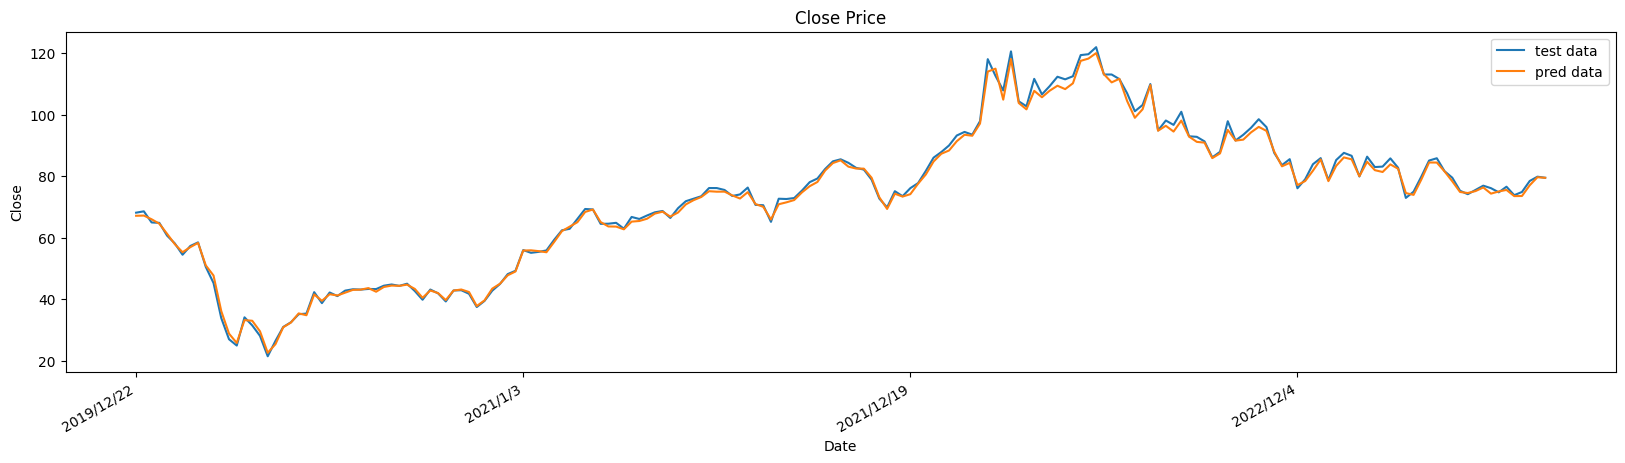

In [79]:
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(figsize=(20,5))

# xdata = db['Date']

ax0.plot(table["Date"][-183:], table["Close"][-183:], label="test data")
ax0.plot(table["Date"][-183:], denormalized_value, label="pred data")

ax0.xaxis.set_major_locator(plt.MultipleLocator(50))
fig.autofmt_xdate() #自动旋转xlabel

ax0.set_title("Close Price")
ax0.set_xlabel("Date")
ax0.set_ylabel("Close")

ax0.legend()

plt.show()

In [61]:
from sklearn.metrics import r2_score
# R_2 = r2_score(y_test,prediction)
# print(R_2)

In [62]:
from torchsummary import summary

# summary(model, (1823, 4, 6))
summary(model,(4, 6))
# del model0

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
import torch
import torchvision
# 导入torchsummary
from torchsummary import summary

# 需要使用device来指定网络在GPU还是CPU运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 建立神经网络模型，这里直接导入已有模型
# model = model().to(device)
model = torchvision.models.vgg11_bn().to(device)
# 使用summary，注意输入维度的顺序
summary(model, input_size=(3, 224, 224))